<a href="https://colab.research.google.com/github/ben900926/CS_CS20024/blob/main/HW5_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
import cv2
import numpy as np
import random
import os

from tqdm import tqdm

from tensorflow import keras
import matplotlib.pyplot as plt



In [ ]:
TRAIN_PATH = "drive/MyDrive/kaggle/train"
TEST_PATH = "drive/MyDrive/kaggle/test"

#TRAIN_PATH = "/kaggle/input/captcha-hacker/train"
#TEST_PATH = "/kaggle/input/captcha-hacker/test"
device = "cuda"
# try device = "cuda" 
# and change your settings/accelerator to GPU if you want it to run faster

# plt Example

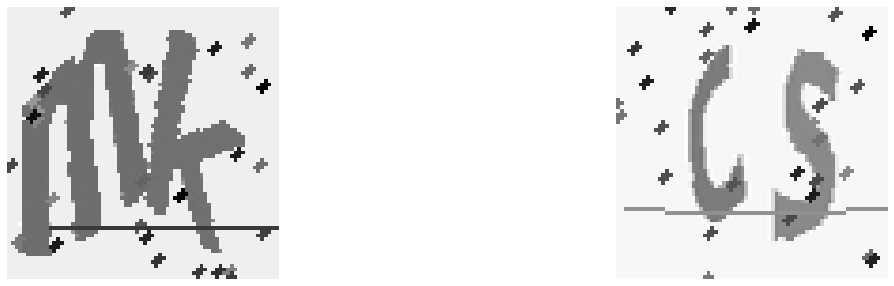

In [ ]:
# plot two examples
def plot_ (img1, img2) :
  plt.figure(figsize = (20,5))
  
  plt.subplot(1,2,1)
  plt.imshow(img1, 'gray')
  
  plt.axis('off')
  
  plt.subplot(1,2,2)
  plt.imshow(img2, 'gray')
  
  plt.axis('off')


path1 = TRAIN_PATH + '/task2/x9S5CJ1tWb2oGf2d.png'
path2 = TRAIN_PATH + '/task2/teBi6eqghtOLsGey.png'

img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

plot_(img1, img2)


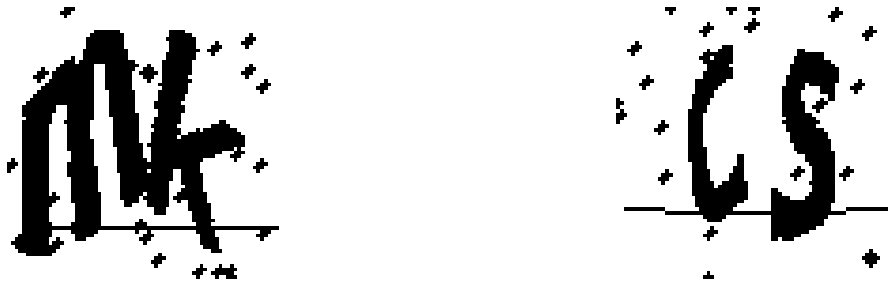

In [ ]:
# adaptive thresholding : Algorithms determine the threshold for a pixel based on its surrounding regions
thresh_img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
thresh_img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
plot_(thresh_img1, thresh_img2)

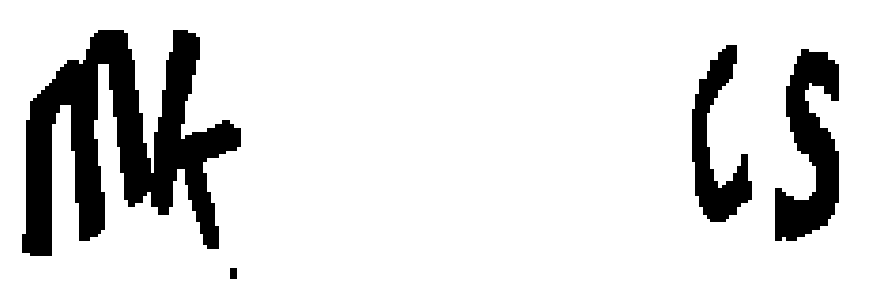

In [ ]:
# Erosion close : used to remove some noise
close_img1 = cv2.morphologyEx(thresh_img1, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
close_img2 = cv2.morphologyEx(thresh_img2, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
plot_(close_img1, close_img2)

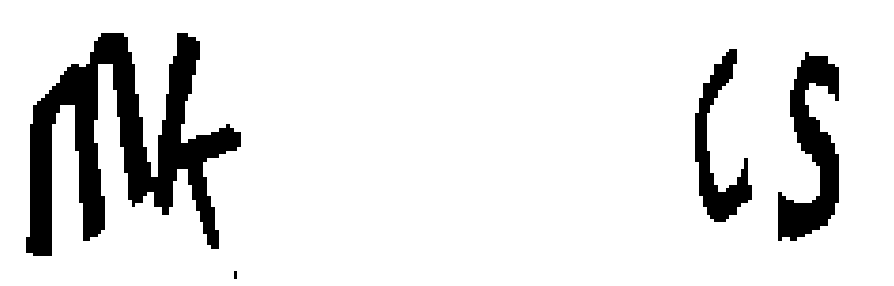

In [ ]:
# Dilation
dilate_img1 = cv2.dilate(close_img1, np.ones((2,2), np.uint8), iterations = 1)
dilate_img2 = cv2.dilate(close_img2, np.ones((2,2), np.uint8), iterations = 1)
plot_(dilate_img1, dilate_img2)

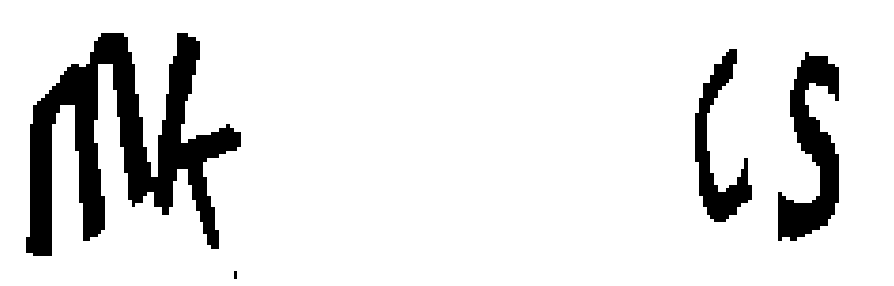

In [ ]:
# Gaussian blurring : help use remove more noise
gauss_img1 = cv2.GaussianBlur(dilate_img1, (1,1), 0)
gauss_img2 = cv2.GaussianBlur(dilate_img2, (1,1), 0)
plot_(gauss_img1, gauss_img2)

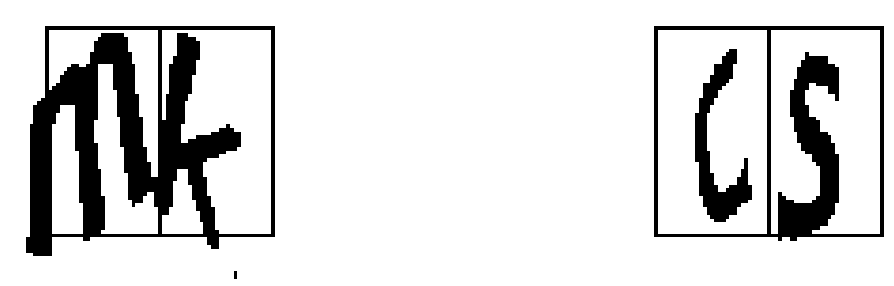

In [ ]:
# parition 2 batch normalization
# each partition: 30 X 55
cv2.rectangle(gauss_img1, (10,5), (40,60), 0, 1)
cv2.rectangle(gauss_img1, (40,5), (70,60), 0, 1)

cv2.rectangle(gauss_img2, (10,5), (40,60), 0, 1)
cv2.rectangle(gauss_img2, (40,5), (70,60), 0, 1)

plot_(gauss_img1, gauss_img2)

# Preprocess image

In [ ]:
# preprocessing step for task 1
def preprocessing(img):
  a_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
  c_img = cv2.morphologyEx(a_img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
  d_img = cv2.dilate(c_img, np.ones((2,2), np.uint8), iterations = 1)
  g_img = cv2.GaussianBlur(d_img, (1,1), 0)

  return g_img


In [ ]:
from tensorflow.keras.utils import img_to_array
from PIL import Image

x_train = [] # [ ['task1/aoRRfheQJeU3LFd4.png' '0'] ['task1/uqctCAnyY2UCgN2A.png' '3']
y_train = []

# read all images in task 2
count = 0
with open(f'{TRAIN_PATH}/annotations.csv', newline='') as csvfile:
  for row in csv.reader(csvfile, delimiter=','):
    if(row[0][:5]!="task2"):
      continue
    if(count%100 == 0):
      print(f"load {count} data")


    count+=1

    img = cv2.imread(os.path.join(TRAIN_PATH, row[0]), cv2.IMREAD_GRAYSCALE)
    img = preprocessing(img)

    # two 30 X 55 digits
    image_list = [img[5:60, 10:40], img[5:60, 40:70]]
    
    for i in range(2):
      x_train.append(img_to_array(Image.fromarray(image_list[i])))
      y_train.append(row[1][i])
    

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train /= 255.0

print(x_train.shape)
print(y_train.shape)



load 0 data
load 100 data
load 200 data
load 300 data
load 400 data
load 500 data
load 600 data
load 700 data
load 800 data
load 900 data
load 1000 data
load 1100 data
load 1200 data
load 1300 data
load 1400 data
load 1500 data
load 1600 data
load 1700 data
load 1800 data
load 1900 data
load 2000 data
load 2100 data
load 2200 data
load 2300 data
load 2400 data
(5000, 55, 30, 1)
(5000,)


[]

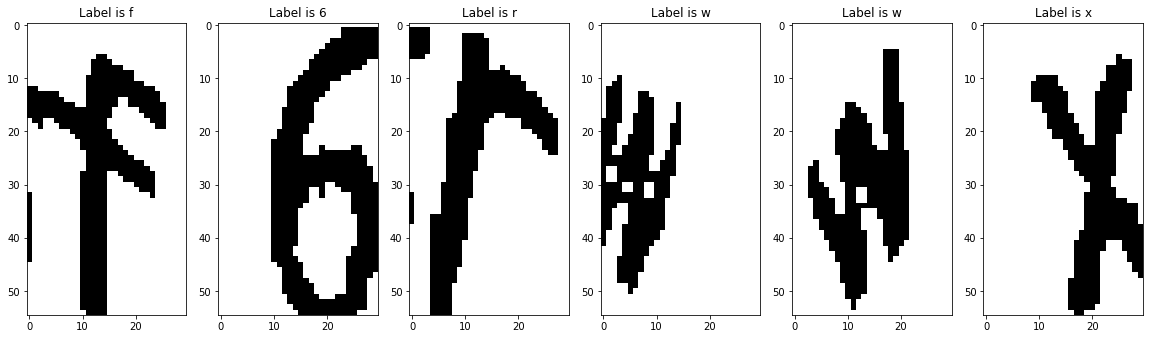

In [ ]:
plt.figure(figsize = (20,6))
x = np.random.randint(0, 630)
for i in range(6) :
  plt.subplot(1,6,i+1)
  plt.imshow(x_train[i+x][:,:,0].squeeze(), 'gray')
  plt.title('Label is ' + str(y_train[i+x]))
plt.plot()

# one hot encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# count label
temp = set(y_train)
for t in temp :
  print('Occurance count of ' + t + ' : ' + str(len(y_train[y_train == t])))

y_train_combine = LabelEncoder().fit_transform(y_train)
y_train_one_hot = OneHotEncoder(sparse = False).fit_transform(y_train_combine.reshape(len(y_train_combine),1))

combine_to_label = {y_train_combine[i] : y_train[i] for i in range(len(y_train))}
print(combine_to_label)
#print(y_train_one_hot)

Occurance count of y : 172
Occurance count of v : 177
Occurance count of a : 186
Occurance count of 8 : 191
Occurance count of h : 188
Occurance count of c : 177
Occurance count of t : 178
Occurance count of 0 : 166
Occurance count of s : 209
Occurance count of 9 : 192
Occurance count of 2 : 187
Occurance count of n : 163
Occurance count of f : 170
Occurance count of w : 162
Occurance count of x : 181
Occurance count of j : 172
Occurance count of d : 167
Occurance count of e : 184
Occurance count of r : 208
Occurance count of 3 : 175
Occurance count of 7 : 208
Occurance count of 5 : 183
Occurance count of p : 166
Occurance count of 1 : 127
Occurance count of 4 : 179
Occurance count of m : 195
Occurance count of k : 169
Occurance count of 6 : 168
{20: 'p', 6: '6', 12: 'd', 5: '5', 14: 'f', 26: 'x', 3: '3', 16: 'j', 19: 'n', 13: 'e', 7: '7', 23: 't', 11: 'c', 2: '2', 9: '9', 24: 'v', 17: 'k', 10: 'a', 15: 'h', 21: 'r', 25: 'w', 1: '1', 18: 'm', 4: '4', 0: '0', 22: 's', 8: '8', 27: 'y'}


# train-test split

In [ ]:
print(x_train.shape)
print(y_train_one_hot.shape)
#print(y_train_one_hot)

(5000, 55, 30, 1)
(5000, 28)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train_one_hot, y_val_one_hot = train_test_split(x_train, y_train_one_hot, test_size=0.1, random_state=1)

# over sampling

In [ ]:
n,w,h,c = x_train.shape
print(n,w,h,c)
x_train = np.reshape(x_train, (n, w*h*c))

4500 55 30 1


In [ ]:
from imblearn.over_sampling import SMOTE
#print(y_train_one_hot)
x_train, y_train_one_hot = SMOTE(sampling_strategy = 'auto', random_state = 1).fit_resample(x_train, y_train_one_hot)

In [ ]:
print(x_train.shape)
print(y_train_one_hot.shape)
x_train = np.reshape(x_train, (x_train.shape[0],w,h,c))
print(x_train.shape)

(5320, 1650)
(5320, 28)
(5320, 55, 30, 1)


# Model Creation

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

from keras.layers import Dropout
from keras.layers import Input
from keras.optimizers import RMSprop

In [ ]:
print(x_train.shape)
print(y_train_one_hot.shape)
print(x_val.shape)
print(y_val_one_hot.shape)

(5320, 55, 30, 1)
(5320, 28)
(500, 55, 30, 1)
(500, 28)


In [ ]:
# cnn
def cnn () :
    
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                        activation='relu', input_shape = (55,30,1)))
  model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                        activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                        activation='relu', input_shape = (55,30,1)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                        activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(28,activation='softmax'))

  # define optimizer
  optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  # compile
  model.compile(optimizer = optimizer, loss='categorical_crossentropy', 
             metrics=["accuracy"])
  return model

# Data augmentaion

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
        
img_gen.fit(x_train)
train_set = img_gen.flow(x_train, y_train_one_hot)
trainX, trainY = train_set.next()

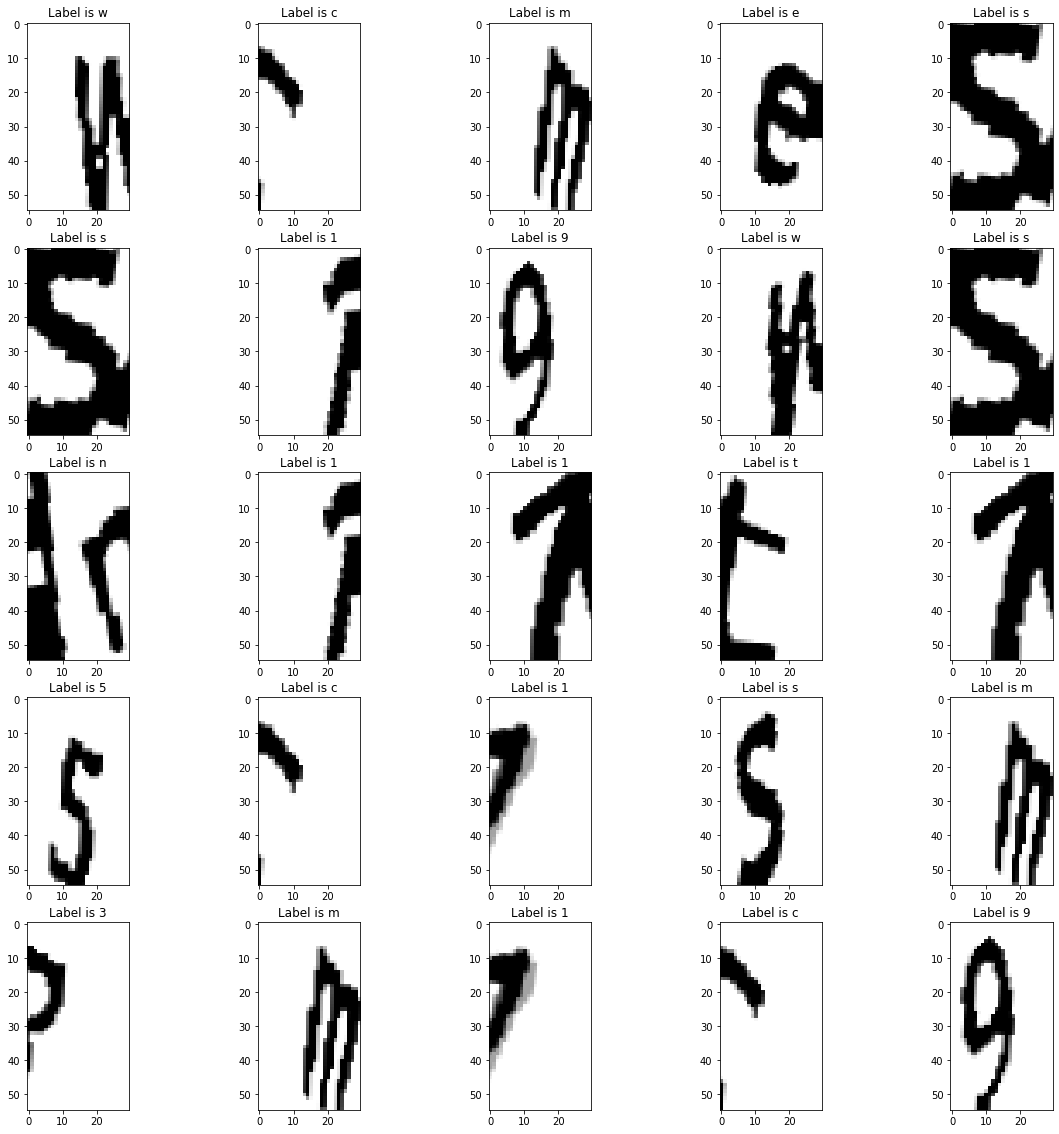

In [ ]:
# showcase
plt.figure(figsize = (20,20))

lo = 0
hi = 32

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(trainX[x][:,:,0].squeeze(), 'gray')
    plt.title('Label is ' + str(combine_to_label[np.argmax(trainY[x])]))
plt.show()

# Model Training

In [ ]:
# check on train set
print(x_train.shape)
print(y_train_one_hot.shape)
# model parameters
model = cnn()
model.summary()

(5320, 55, 30, 1)
(5320, 28)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 55, 30, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 30, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 27, 15, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 15, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 15, 64)        36928     
                         

## Model checkpoint

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau # learning rate decreasing

check_point = ModelCheckpoint('drive/MyDrive/kaggle/task2_model.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)
# reduction on lr
reduce = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor=0.5, min_lr=0.00001)
# check on train set
print(x_train.shape)
print(y_train_one_hot.shape)

(5320, 55, 30, 1)
(5320, 28)


In [ ]:
# start training
batch_size = 128
history = model.fit(img_gen.flow(x_train, y_train_one_hot, batch_size = batch_size), 
          validation_data = (x_val, y_val_one_hot), epochs = 30, 
          steps_per_epoch = len(x_train)// batch_size, callbacks = [check_point, reduce])

Epoch 1/30
41/41 [==============================] - ETA: 0s - loss: 3.1886 - accuracy: 0.0921
Epoch 1: val_accuracy improved from -inf to 0.31200, saving model to drive/MyDrive/kaggle/task2_model.h5
41/41 [==============================] - 12s 72ms/step - loss: 3.1886 - accuracy: 0.0921 - val_loss: 2.3540 - val_accuracy: 0.3120 - lr: 0.0010
Epoch 2/30
41/41 [==============================] - ETA: 0s - loss: 2.3237 - accuracy: 0.3007
Epoch 2: val_accuracy improved from 0.31200 to 0.56200, saving model to drive/MyDrive/kaggle/task2_model.h5
41/41 [==============================] - 2s 58ms/step - loss: 2.3237 - accuracy: 0.3007 - val_loss: 1.3930 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 3/30
40/41 [============================>.] - ETA: 0s - loss: 1.8175 - accuracy: 0.4443
Epoch 3: val_accuracy improved from 0.56200 to 0.68000, saving model to drive/MyDrive/kaggle/task2_model.h5
41/41 [==============================] - 2s 50ms/step - loss: 1.8099 - accuracy: 0.4470 - val_loss: 1.0517 - v

Text(0.5, 1.0, 'Model accuracy wrt Epoch')

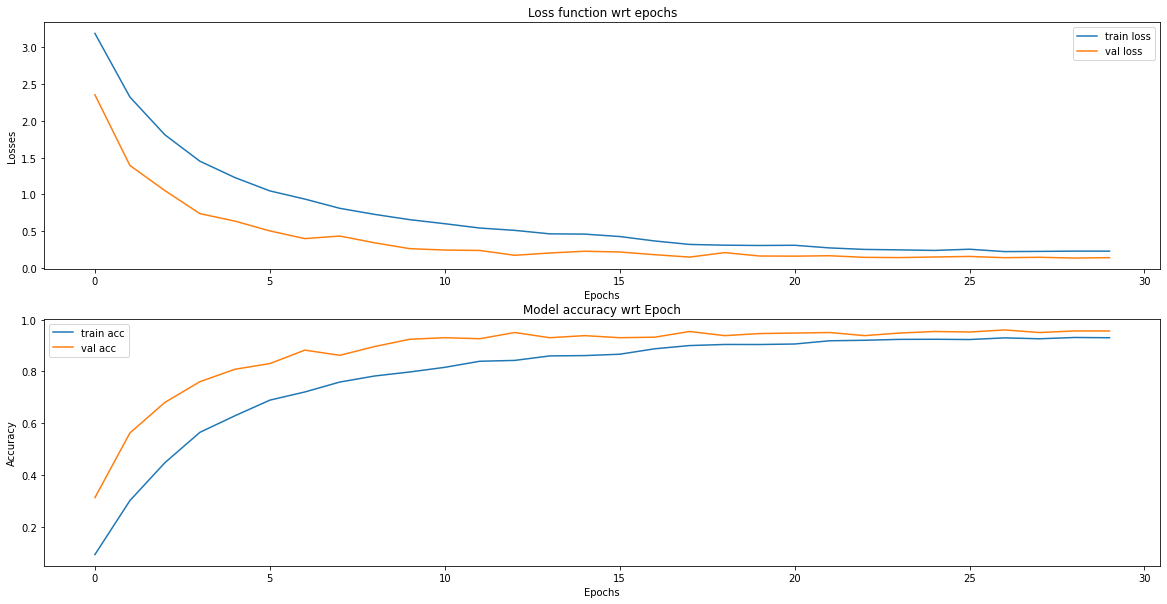

In [ ]:
# plot training result
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')

# Prediction

In [ ]:
from keras.models import load_model

# need 
model = load_model("drive/MyDrive/kaggle/task2_model.h5")
# make prediction on x_test
x_test = []
count = 0
for image_p in os.listdir( os.path.join(TEST_PATH, 'task2') ):
  if(count % 1000 == 0):
    print(f"{count} data read")
  count+=1

  img = cv2.imread( os.path.join(TEST_PATH, 'task2', image_p), cv2.IMREAD_GRAYSCALE )
  img = preprocessing(img)
  # two 30 X 55 digits
  image_list = [img[5:60, 10:40], img[5:60, 40:70]]
  for i in range(2):
    x_test.append(img_to_array(Image.fromarray(image_list[i])))

0 data read
1000 data read
2000 data read


In [ ]:
x_test = np.array(x_test)
print(x_test.shape)
pred = model.predict(x_test)
print(pred[0])
pred = np.argmax(pred, axis=1)
print(pred[0])
print(pred.shape)

# write submission csv for task 2
with open('drive/MyDrive/kaggle/submission2.csv', 'w', newline='') as csvFile:
  csv_writer = csv.writer(csvFile)
  i = 0
  for image_p in os.listdir( os.path.join(TEST_PATH, 'task2') ):
    csv_writer.writerow( ['task2/'+image_p, str(combine_to_label[pred[i]])+str(combine_to_label[pred[i+1]])] ) 
    i += 2

(5000, 55, 30, 1)
157/157 [==============================] - 0s 3ms/step
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
5
(5000,)


In [ ]:
# check for submission.csv
task1, task2, task3 = 0,0,0
with open('drive/MyDrive/kaggle/submission2.csv', newline='') as csvFile:
    rows = csv.reader(csvFile)

    for row in rows:
        if(row[0][:5]=="task1"):
            task1+=1
        elif(row[0][:5]=="task2"):
            task2+=1
        elif(row[0][:5]=="task3"):
            task3+=1

    print(task1, task2, task3)

0 2500 0


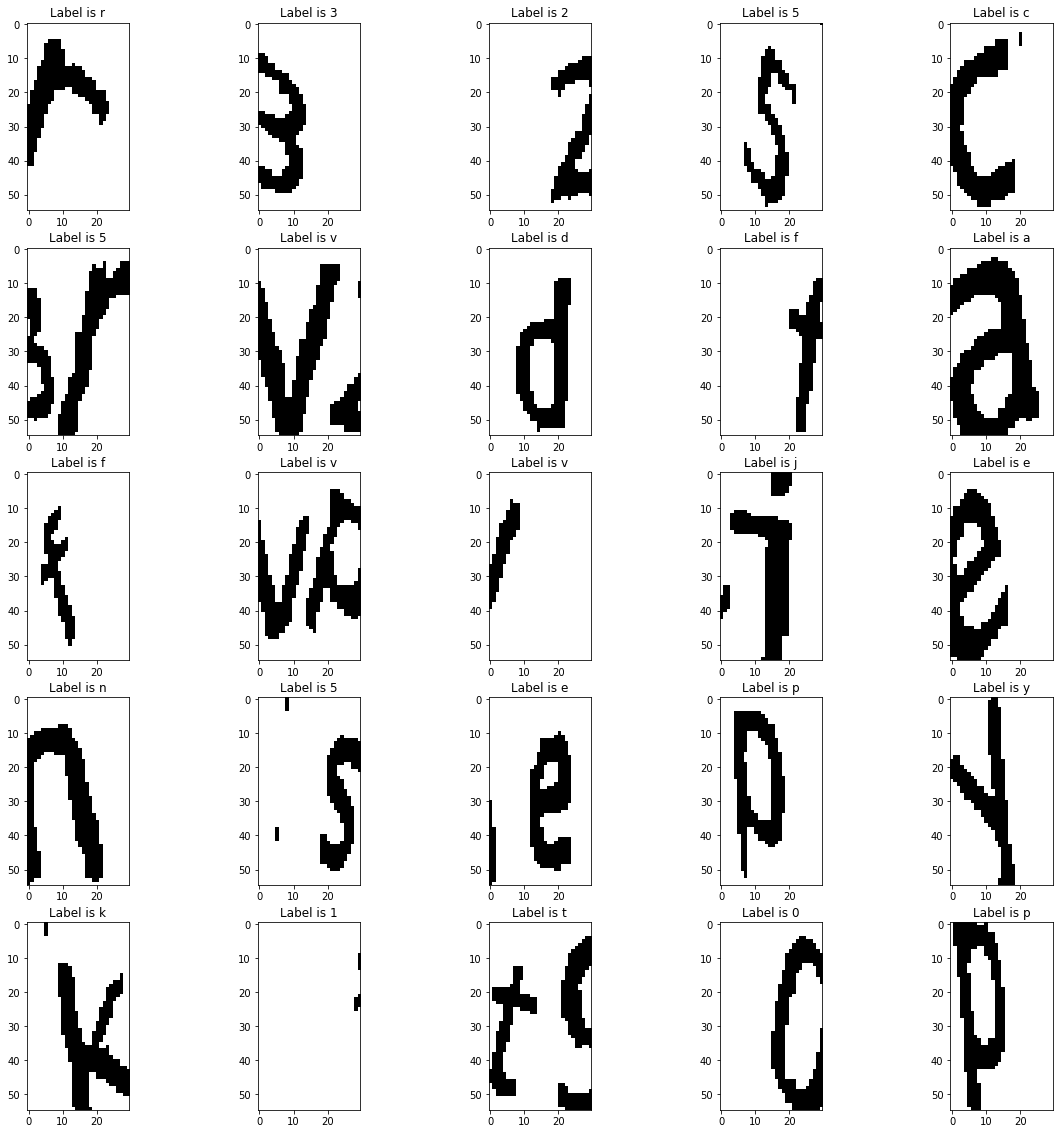

In [ ]:
# take a look at prediction
plt.figure(figsize = (20,20))

lo = 0
hi = 4750

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(x_test[x][:,:,0].squeeze(), 'gray')
    plt.title('Label is ' + str(combine_to_label[pred[x]]))
plt.show()